In [1]:
%matplotlib widget

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.patches

In [3]:
df = pd.read_excel('~/Downloads/MSCA Gantt.xlsx', index_col=0)

df.index = df.index.str.strip()
df['stop'] = df['stop'] + 1  # make it non-inclusive
df['duration'] = df['stop'] - df['start']

assert df.index.is_unique
assert df['WP'].notna().all()

assert (df['duration'].dropna() > 0).all(), df.loc[df['duration'] <= 0, 'name'].values


In [4]:
def place_elements(df):
    """
    Place tasks bars in the y axis.
    If two consecutive tasks don't overlap they'll be place in the same row.
    Non-task items inherit the last task y value.
    """

    tasks = df[df['type'] == 'T']

    tasks = tasks.sort_values(['WP', 'start', 'stop'], ascending=(True, True, False))

    ys = pd.Series(np.nan, index=df.index)

    ys.loc[tasks.index[0]] = 0

    for i, (t0, t1) in enumerate(zip(tasks.index[:-1], tasks.index[1:])):

        if tasks.loc[t0, 'WP'] != tasks.loc[t1, 'WP']:  # different WP
            ys.loc[t1] = ys.max() + 2

        elif tasks.loc[t0, 'stop'] > tasks.loc[t1, 'start']:  # overlap
            ys.loc[t1] = ys.max() + 1

        else:
            ys.loc[t1] = ys.loc[t0]

    ys = ys.ffill().bfill()

    return ys


def layout_tasks(df):
    y = place_elements(df)

    df['x0'] = df['start'] - 0.5  # start of the month
    df['w'] = df['duration']

    df['y0'] = y
    df['h'] = 0.

    df.loc[df['type'] == 'T', 'y0'] -= 0.5
    df.loc[df['type'] == 'T', 'h'] = 1


def layout_wp(df):

    for wp, tasks in df[df['type'] == 'T'].groupby('WP'):
        df.loc[wp, 'start'] = tasks['start'].min()
        df.loc[wp, 'stop'] = tasks['stop'].max()
        df.loc[wp, 'duration'] = df.loc[wp, 'stop'] - df.loc[wp, 'start']

        df.loc[wp, 'x0'] = tasks['x0'].min()
        df.loc[wp, 'y0'] = tasks['y0'].min()

        df.loc[wp, 'w'] = (tasks['x0'] + tasks['w']).max() - df.loc[wp, 'x0']
        df.loc[wp, 'h'] = (tasks['y0'] + tasks['h']).max() - df.loc[wp, 'y0']


def shrink_boxes(df, who, length=0.1, thickness=0.2):
    df.loc[who, 'x0'] = df.loc[who, 'x0'] + length * 0.5
    df.loc[who, 'w'] = df.loc[who, 'duration'] - length
    df.loc[who, 'y0'] = df.loc[who, 'y0'] + thickness * 0.5
    df.loc[who, 'h'] = df.loc[who, 'h'] - thickness


def layout_secondment(df):
    df.loc[df['type'] == 'S', 'y0'] = df['y0'].min()
    df.loc[df['type'] == 'S', 'h'] = (df['y0'] + df['h']).max(0) - df['y0'].min()


layout_tasks(df)

layout_wp(df)

layout_secondment(df)

shrink_boxes(df, df['type'] == 'T')
shrink_boxes(df, df['type'] == 'WP', length=0.0, thickness=-0.5)
shrink_boxes(df, df['type'] == 'S', length=0.0, thickness=-2)

In [5]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np

def add_asymmetric_rounded_rect_from_corner( xy, width, height,
                                            round_tl=False, round_tr=True,
                                            round_br=True, round_bl=False,
                                            radius=0.15,
                                            edgecolor='black', facecolor='none',
                                            linewidth=1, **kwargs):
    x0, y0 = xy
    x1, y1 = x0 + width, y0 + height
    r = min(radius, width / 2, height / 2)

    # Shortcut for arc control: 4-point approximation of quarter circle
    K = 0.552284749831  # = 4*(sqrt(2)-1)/3, good approximation

    path = []
    codes = []

    def move_to(x, y):
        path.append((x, y))
        codes.append(Path.MOVETO)

    def line_to(x, y):
        path.append((x, y))
        codes.append(Path.LINETO)

    def curve_to(x1, y1, x2, y2, x, y):
        path.extend([(x1, y1), (x2, y2), (x, y)])
        codes.extend([Path.CURVE4, Path.CURVE4, Path.CURVE4])

    # Start from bottom-left
    if round_bl:
        move_to(x0, y0 + r)
    else:
        move_to(x0, y0)

    # Left edge
    if round_bl:
        line_to(x0, y1 - r if round_tl else y1)
        curve_to(x0, y0 + r * (1 - K), x0 + r * (1 - K), y0, x0 + r, y0)
    else:
        line_to(x0, y1 if not round_tl else y1 - r)

    # Top-left corner
    if round_tl:
        line_to(x0 + r, y1)
        curve_to(x0 + r * (1 - K), y1, x0, y1 - r * (1 - K), x0, y1 - r)

    # Top edge
    if round_tr:
        line_to(x1 - r, y1)
    else:
        line_to(x1, y1)

    # Top-right corner
    if round_tr:
        curve_to(x1 - r * (1 - K), y1, x1, y1 - r * (1 - K), x1, y1 - r)

    # Right edge
    if round_br:
        line_to(x1, y0 + r)
    else:
        line_to(x1, y0)

    # Bottom-right corner
    if round_br:
        curve_to(x1, y0 + r * (1 - K), x1 - r * (1 - K), y0, x1 - r, y0)

    # Bottom edge
    if round_bl:
        line_to(x0 + r, y0)
    else:
        line_to(x0, y0)

    codes.append(Path.CLOSEPOLY)
    path.append(path[0])

    patch = patches.PathPatch(Path(path, codes),
                               facecolor=facecolor,
                               edgecolor=edgecolor,
                               linewidth=linewidth, **kwargs)

    return patch


''

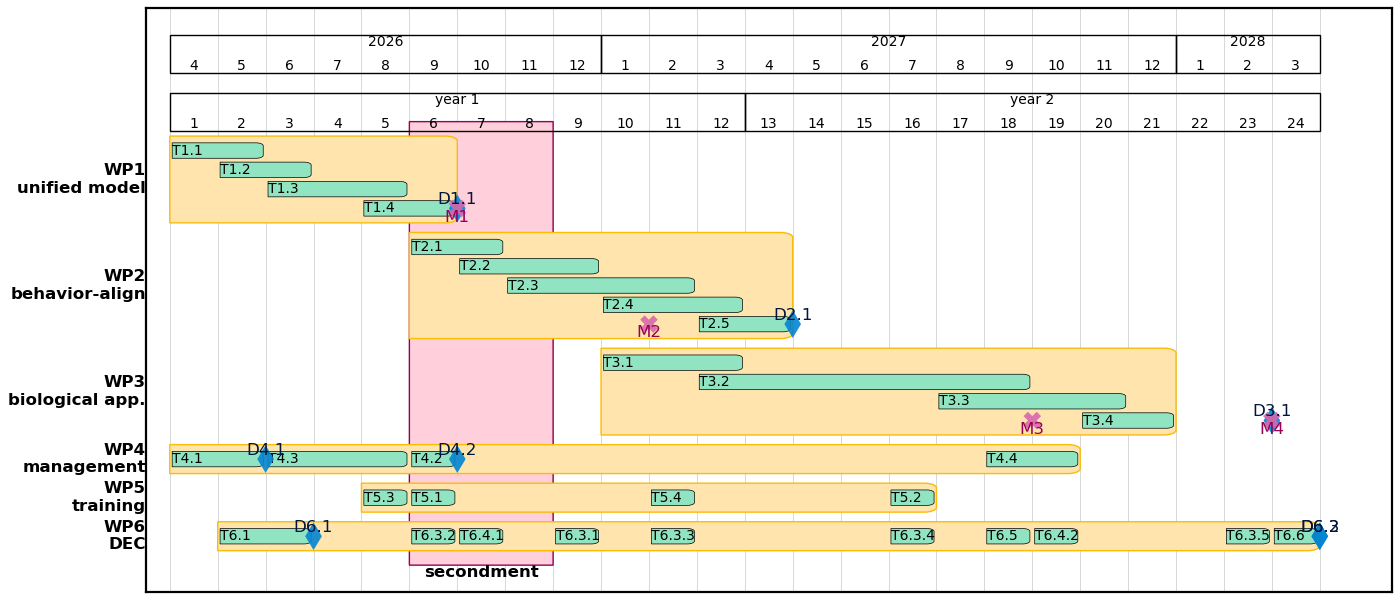

In [6]:
def label_months(ax, months, y1, base_year=None, height=2):

    y0 = y1 - height

    month_idcs = np.arange(len(months)) + 1

    for i, m in zip(month_idcs, months):
        ax.text(
            i,
            y1,
            f'{m}',
            zorder=1e6,
            ha='center',
            va='bottom',
            **STYLE['time']['text'],
        )

    ends = month_idcs[months == 12]
    ends = np.concat([month_idcs[[0]] - 1, ends, month_idcs[[-1]]]) + .5

    for i, (x0, x1) in enumerate(zip(ends[:-1], ends[1:])):
        rect = matplotlib.patches.Rectangle(
            (x0, y0),
            width=x1 - x0,
            height=y1 - y0,
            **{
                **dict(
                    zorder=1e5
                ),
                **STYLE['time']['box'],
            },
        )
        ax.add_patch(rect)

        ax.text(
            (x0 + x1) * .5,
            y0,
            f'year {i+1}' if base_year is None else base_year + i,
            **{
                **dict(
                    zorder=1e6,
                    ha='center',
                    va='top',
                ),
                **STYLE['time']['text']
            },
        )


def create_fig():
    f, ax = plt.subplots(
        dpi=200,
        figsize=(7, 3),
        constrained_layout=True,
    )

    ax.set_xticks(np.arange(1, 24+1))

    for m in np.arange(1, 25.5, 1):
        ax.axvline(m - 0.5, color='xkcd:silver', linewidth=.25)

    months = np.arange(1, 25)
    label_months(ax, months, y1=-1)

    first_month = 4  # April
    months = (months - 2 + first_month) % 12 + 1
    label_months(ax, months, y1=-4, base_year=2026)

    ax.tick_params(labeltop=False, bottom=False, labelbottom=False)

    ax.set(
        xlim=(0, 26)
    )

    ax.relim()           # Recalculate limits based on all artists
    ax.autoscale_view()  # Autoscale view using the new limits

    ax.invert_yaxis()

    return ax


def add_block(
    ax,
    name,
    y0, x0, w, h,
):
    rect = add_asymmetric_rounded_rect_from_corner(
        (x0, y0),
        width=w,
        height=h,
        **{
            **dict(zorder=1e5),
            **STYLE['T']['box'],
        },
    )

    ax.text(
        x0,
        y0 + h * 0.5,
        f'{name}',
        **{
            **dict(
                va='center',
                ha='left',
                zorder=1e6,
            ),
            **STYLE['T']['text']
        },
    )

    ax.add_patch(rect)


def plot_wp(ax, df):

    tasks = df[df['type'] == 'T']

    tasks = tasks.sort_values(['start', 'stop'], ascending=(True, False))

    for (i, k) in enumerate(tasks.index):
        add_block(
            ax,
            name=k,
            x0=tasks.loc[k, 'x0'],
            y0=tasks.loc[k, 'y0'],
            w=tasks.loc[k, 'w'],
            h=tasks.loc[k, 'h'],
        )

    wp = df[df['type'] == 'WP']
    assert len(wp) == 1
    wp = wp.iloc[0]
    wp_rect = add_asymmetric_rounded_rect_from_corner(
        (wp['x0'], wp['y0']),
        wp['w'],
        wp['h'],
        radius=.25,
        **STYLE['WP']['box'],
    )

    ax.text(
        0,
        #wp['x0'],
        wp['y0'] + wp['h'] * 0.5,
        wp.name + '\n' + wp['short'],
        **{
            **dict(rotation=0, va='center', ha='right'),
            **STYLE['WP']['text'],
        }
    )

    ax.add_patch(wp_rect)


def plot_deliverables(ax, deliverables):
    for k in deliverables.index:
        x = deliverables.loc[k, 'start'] + 0.5
        y = deliverables.loc[k, 'y0'] + deliverables.loc[k, 'h'] * .5
        ax.scatter(
            [x],
            [y],
            **{
                **dict(zorder=1e6),
                **STYLE['D']['marker'],
            },
        )

        ax.text(
            x, y, f'{k}\n',
            **{
                **dict(va='center', ha='center', zorder=1e6,),
                **STYLE['D']['text']
            },
        )


def plot_milestones(ax, milestones):
    for k in milestones.index:
        x = milestones.loc[k, 'start'] + 0.5
        y = milestones.loc[k, 'y0'    ] + milestones.loc[k, 'h'] * .5
        ax.scatter(
            [x],
            [y],
            **{
                **dict(zorder=1e6),
                **STYLE['M']['marker'],
            },
        )

        ax.text(
            x, y, f'\n{k}',
            **{
                **dict(va='center', ha='center', zorder=1e6),
                **STYLE['M']['text'],
            },
        )


STYLE = {
    'time':{
        'box': dict(
            edgecolor='k',
            facecolor='none',
            alpha=1,
            linewidth=0.5,
        ),
        'text': dict(
            fontsize=5,
        ),
    },
    'T': {
        'box': dict(
            facecolor='xkcd:light teal',
            edgecolor='k',
            linewidth=0.25,
            alpha=1,
        ),
        'text': dict(
            fontsize=5,
        ),
    },

    'WP': {
        'box': dict(
            facecolor='xkcd:pale peach',
            edgecolor='xkcd:golden rod',
            linewidth=0.5,
            alpha=1,
            zorder=1e3,
        ),
        'text': dict(
            fontsize=6,
            color='k',
            weight='bold',
        ),
    },

    'S': {
        'box': dict(
            facecolor='xkcd:pale pink',
            edgecolor='xkcd:dark magenta',
            linewidth=0.5,
            alpha=1,
            zorder=1e2,
            radius=0,
        ),
        'text': dict(
            fontsize=6,
            color='k',
            weight='bold',
            zorder=1e8,
        ),
    },

    'D': {
        'marker': dict(
            facecolor='xkcd:cerulean',
            edgecolor='none',
            linewidth=0.25,
            alpha=0.9,
            s=50,
            marker='d',
        ),
        'text': dict(
            fontsize=6,
            zorder=1e8,
            rotation=0,
            ha='center',
            va='center',
            color='xkcd:navy'
        ),
    },

    'M': {
        'marker': dict(
            facecolor='xkcd:pale magenta',
            edgecolor='none',
            linewidth=0.25,
            marker='X',
            alpha=0.9,
            s=40,
        ),
        'text': dict(
            fontsize=6,
            zorder=1e8,
            color='xkcd:dark magenta'
        ),
    },
}


ax = create_fig()

for wp, sdf in df.groupby('WP'):
    plot_wp(ax, sdf)

plot_deliverables(ax, df[df['type'] == 'D'])
plot_milestones(ax, df[df['type'] == 'M'])


ax.tick_params(
    left=False,
    labelleft=False,
)


def plot_secondments(ax, secondments):

    for k in secondments.index:
        s = secondments.loc[k]

        rect = add_asymmetric_rounded_rect_from_corner(
            (s['x0'], s['y0']),
            s['w'],
            s['h'],
            **{
                **dict(radius=.25),
                **STYLE['S']['box'],
            },
        )

        ax.text(
            # 0,
            s['x0'] + s['w'] * .5,
            s['y0'] + s['h'],
            str(s['short']),
            **{
                **dict(rotation=0, va='top', ha='center'),
                **STYLE['S']['text'],
            }
        )

        ax.add_patch(rect)



plot_secondments(ax, df[df['type'] == 'S'])
ax.relim()
ax.autoscale_view()

;


